## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import os
import shutil
import random
from tqdm import tqdm
from random import seed
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
  
seed(1121)

## Load data



Unzip

In [2]:
# !unzip ../datasets/Cinc2019/training_setA.zip
# !unzip ../datasets/Cinc2019/training_setB.zip
# !ls ../datasets/Cinc2019/

data_all      training_setA training_setB


Sort

In [ ]:
!rsync -a ../datasets/Cinc2019/training_setA/ ../datasets/Cinc2019/data_all/
!rsync -a ../datasets/Cinc2019/training_setB/ ../datasets/Cinc2019/data_all/

In [3]:
!ls -1U ../datasets/Cinc2019/training_setA/ | wc -l
!ls -1U ../datasets/Cinc2019/training_setB/ | wc -l
!ls -1U ../datasets/Cinc2019/data_all/ | wc -l

   20336
   20000
   40336


In [2]:
path_all = '../datasets/Cinc2019/data_all/'
path_setA = '../datasets/Cinc2019/training_setA/'
path_setB = '../datasets/Cinc2019/training_setB/'

In [3]:
patient_id = sorted(os.listdir(path_all))
patient_id = list(filter(lambda x: x !="index.html" and x != ".DS_Store", patient_id))
print('Total patient number: ',len(patient_id))

patient_id_setA = sorted(os.listdir(path_setA))
patient_id_setA = list(filter(lambda x: x !="index.html" and x != ".DS_Store", patient_id_setA))
print('Hospital A patient number: ',len(patient_id_setA))

patient_id_setB = sorted(os.listdir(path_setB))
patient_id_setB = list(filter(lambda x: x !="index.html" and x != ".DS_Store", patient_id_setB))
print('Hospital B patient number: ',len(patient_id_setB))

Total patient number:  40336
Hospital A patient number:  20336
Hospital B patient number:  20000


## Split into sepsis and non-sepsis

In [4]:
def find_sepsis_file(data_path_dir):
    id_nonsepsis = []
    id_sepsis = []
    for psv in tqdm(os.listdir(data_path_dir)):
        if psv == '.DS_Store': continue
        pid = pd.read_csv(os.path.join(data_path_dir, psv), sep='|')
        if 1 in np.array(pid.SepsisLabel):
            id_sepsis.append(psv)
        else:
            id_nonsepsis.append(psv)
    return (id_nonsepsis, id_sepsis)

In [11]:
id_nonsepsis, id_sepsis = find_sepsis_file(path_all)

100%|██████████| 40337/40337 [02:53<00:00, 232.92it/s]


In [12]:
print('Number of sepsis patients:', len(id_sepsis))
print('Number of non sepsis patients:', len(id_nonsepsis))

Number of sepsis patients: 2932
Number of non sepsis patients: 37404


## Train-Val-Test Split


In [5]:
len_train_sepsis = round(0.7*len(id_sepsis))
print(len_train_sepsis)
len_val_sepsis = round(0.15*len(id_sepsis))
print(len_val_sepsis)
len_test_sepsis = round(0.15*len(id_sepsis))
print(len_test_sepsis)
len_train_sepsis + len_val_sepsis + len_test_sepsis == len(id_sepsis)

NameError: name 'id_sepsis' is not defined

As the test set should be set here as the same length of sepsis

In [15]:
len_train_nonsepsis = round(0.5*(len(id_nonsepsis)-len_test_sepsis))
print(len_train_nonsepsis)
len_val_nonsepsis = round(0.5*(len(id_nonsepsis)-len_test_sepsis))
print(len_val_nonsepsis)
len_test_nonsepsis = len_test_sepsis
print(len_test_nonsepsis)
len_train_nonsepsis + len_val_nonsepsis + len_test_nonsepsis == len(id_nonsepsis)

18482
18482
440


True

In [16]:
len_train = len_train_sepsis + len_train_nonsepsis
print(len_train)
len_val = len_val_sepsis + len_val_nonsepsis
print(len_val)
len_test = len_test_sepsis + len_test_nonsepsis
print(len_test)
len_train + len_val + len_test == len(patient_id)

20534
18922
880


True

In [17]:
train_id_sepsis = random.sample(id_sepsis, len_train_sepsis)
val_id_sepsis = random.sample(set(id_sepsis) - set(train_id_sepsis), len_val_sepsis)
test_id_sepsis = set(id_sepsis) - set(train_id_sepsis) - set(val_id_sepsis)

In [18]:
train_id_nonsepsis = random.sample(id_nonsepsis, len_train_nonsepsis)
val_id_nonsepsis = random.sample(set(id_nonsepsis) - set(train_id_nonsepsis), len_val_nonsepsis)
test_id_nonsepsis = set(id_nonsepsis) - set(train_id_nonsepsis) - set(val_id_nonsepsis)

In [19]:
train_id = train_id_sepsis+ train_id_nonsepsis
val_id = val_id_sepsis + val_id_nonsepsis
test_id = list(test_id_sepsis) + list(test_id_nonsepsis)

sepsis_id = train_id_sepsis + val_id_sepsis
nonsepsis_id = train_id_nonsepsis + val_id_nonsepsis

In [23]:
np.save('../models_adults/data/data_Cinc2019/test_set.npy',test_id)
np.save('../models_adults/data/data_Cinc2019/train_sepsis.npy',sepsis_id)
np.save('../models_adults/data/data_Cinc2019/train_nonsepsis.npy',nonsepsis_id)

## Pre-process dataset

### Helper Functions

Function 1: Fill the missing value

In [6]:
# function to fill missing values
def impute_missing_vals(df, attributes):

    """
    function that imputes missing values.
    
    @param df: dataframe that has missing values to be
               imputed
           attributes: list of String, attributes of dataframe
    @return df_clean: dataframe without missing values

    """
    
    """
    fill missing values by the closest values first
    ffill to fill missing values in the tail
    bfill to fill missing values in the head
    """
    # copy df
    df_clean = df.copy()
    for att in attributes:
        if df_clean[att].isnull().sum() == len(df_clean):
            df_clean[att] = df_clean[att].fillna(0)
        elif df_clean[att].isnull().sum() == len(df_clean) - 1:
            df_clean[att] = df_clean[att].ffill().bfill()
        else:
            df_clean[att] = df_clean[att].interpolate(method='nearest', limit_direction='both')
            df_clean[att] = df_clean[att].ffill().bfill()
    
    return df_clean

Function 2: Generate new feature columns

In [7]:
# function to add new columns containing as mang features as possible
def new_features(df):
  #attributes that are worked on: HR, Resp, Temp

  #copy df
  df_dev = df.copy()

  # three standard deviation for HR -> HR_dev_1, HR_dev_2, HR_dev_3
  hr = df_dev['HR']
  hr_len = len(hr)
  hr_dev_1 = hr.copy()
  hr_dev_2 = hr.copy()
  hr_dev_3 = hr.copy()
  for i, j in hr_dev_1.iteritems():
    if i > hr_len - 5:
      hr_dev_1[i] = hr[i:hr_len].std()
    else:
      hr_dev_1[i] = hr[i:i+5].std()
  hr_dev_1[hr_len-1] = hr_dev_1[hr_len-2]
  df_dev['HR_dev_1'] = hr_dev_1

  for i, j in hr_dev_2.iteritems():
    if i > hr_len - 10:
      hr_dev_2[i] = hr[i:hr_len].std()
    else:
      hr_dev_2[i] = hr[i:i+10].std()
  hr_dev_2[hr_len-1] = hr_dev_2[hr_len-2]
  df_dev['HR_dev_2'] = hr_dev_2

  for i, j in hr_dev_3.iteritems():
    if i > hr_len - 20:
      hr_dev_3[i] = hr[i:hr_len].std()
    else:
      hr_dev_3[i] = hr[i:i+20].std()
  hr_dev_3[hr_len-1] = hr_dev_3[hr_len-2]
  df_dev['HR_dev_3'] = hr_dev_3


  # three standard deviation for Resp -> Resp_dev_1, Resp_dev_2, Resp_dev_3
  rr = df_dev['RR']
  rr_len = len(rr)
  rr_dev_1 = rr.copy()
  rr_dev_2 = rr.copy()
  rr_dev_3 = rr.copy()
  for i, j in rr_dev_1.iteritems():
    if i < rr_len -5:
      rr_dev_1[i] = rr[i:rr_len].std()
    else:
      rr_dev_1[i] = rr[i:i+5].std()
  rr_dev_1[rr_len-1] = rr_dev_1[rr_len-2]
  df_dev['RR_dev_1'] = rr_dev_1

  for i, j in rr_dev_2.iteritems():
    if i < rr_len -10:
      rr_dev_2[i] = rr[i:rr_len].std()
    else:
      rr_dev_2[i] = rr[i:i+10].std()
  rr_dev_2[rr_len-1] = rr_dev_2[rr_len-2]
  df_dev['RR_dev_2'] = rr_dev_2

  for i, j in rr_dev_3.iteritems():
    if i < rr_len -20:
      rr_dev_3[i] = rr[i:rr_len].std()
    else:
      rr_dev_3[i] = rr[i:i+20].std()
  rr_dev_3[rr_len-1] = rr_dev_3[rr_len-2]
  df_dev['RR_dev_3'] = rr_dev_3

  # three standard deviation for Temp -> Temp_dev_1, Temp_dev_2, Temp_dev_3
  t = df_dev['Temp']
  t_len = len(t)
  t_dev_1 = t.copy()
  t_dev_2 = t.copy()
  t_dev_3 = t.copy()
  for i, j in t_dev_1.iteritems():
    if i < t_len - 5:
      t_dev_1[i] = t[i:t_len].std()
    else:
      t_dev_1[i] = t[i:i+5].std()
  t_dev_1[t_len-1] = t_dev_1[t_len-2]
  df_dev['Temp_dev_1'] = t_dev_1

  for i, j in t_dev_2.iteritems():
    if i < t_len - 10:
      t_dev_2[i] = t[i:t_len].std()
    else:
      t_dev_2[i] = t[i:i+10].std()
  t_dev_2[t_len-1] = t_dev_2[t_len-2]
  df_dev['Temp_dev_2'] = t_dev_2

  for i, j in t_dev_3.iteritems():
    if i < t_len - 20:
      t_dev_3[i] = t[i:t_len].std()
    else:
      t_dev_3[i] = t[i:i+20].std()
  t_dev_3[t_len-1] = t_dev_3[t_len-2]
  df_dev['Temp_dev_3'] = t_dev_3

  # features for indicating bradycardia and tachycardia
  brady = hr.copy()
  tachy = hr.copy()
  for i,j in brady.iteritems():
    if hr[i] < 60:
      brady[i] = True
    else:
      brady[i] = False
    if hr[i] > 100:
      tachy[i] = True
    else:
      tachy[i] = False
  df_dev['Bradycardia'] = brady
  df_dev['Tachycardia'] = tachy

  # features for indicating Hypothermia, Hyperthermia(Fever) and Hyperpyrexia
  hypothermia = t.copy()
  fever = t.copy()
  hyperpyrexia = t.copy()
  for i,j in t.iteritems():
    if t[i] <35:
      hypothermia[i] = True
    else:
      hypothermia[i] = False
    if t[i] >37.5:
      fever[i] = True
    else:
      fever[i] = False
    if t[i] >40:
      hyperpyrexia[i] = True
    else:
      hyperpyrexia[i] = False
  df_dev['Hypothermia'] = hypothermia
  df_dev['Fever'] = fever
  df_dev['Hyperpyrexia'] = hyperpyrexia

  return df_dev


### Generate Baseline Data

In [26]:
!mkdir -p ../datasets/Cinc2019/baseline_all

In [38]:
# impute missing values and create clean dfs for all patients
for p in tqdm(patient_id):
    
    # read in patient data
    df = pd.read_csv(path_all + p, sep = "|")

    # drop features that doesn't exist in MIMIC-III
    df_dropped = df.drop(['FiO2', 'PaCO2', 'SaO2', 'AST','Alkalinephos', 'Bilirubin_direct',
                            'Phosphate', 'Bilirubin_total','TroponinI', 'Hct', 'Hgb', 'Fibrinogen',
                            'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'EtCO2'], axis = 1)
    
    # rename the features to matche the ones in MIMIC-III
    df_renamed = df_dropped.rename(columns = {'O2Sat':'SaO2', 'Resp':'RR', 'pH':'PH', 'Lactate':'Lactic', 
                                                'Platelets':'Platelet', 'Age':'age', 'Gender':'gender', 
                                                'SepsisLabel':'sepsis'})
    
    # add a column for subject_id
    p = p[1:len(p)-4]
    df_renamed['subject_id'] = p
    
    # impute missing values
    attributes = df_renamed.columns
    df_filled = impute_missing_vals(df_renamed, attributes)
    
    # save new patient data
    save_path = '../datasets/Cinc2019/baseline_all/'
    df_filled.to_csv(save_path + 'p' + p + '.csv', sep=',', index = False)     

    if np.any(pd.isnull(df_filled)): break
    
    print(p)

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000050
000051
000052
000053
000054
000055
000056
000057
000058
000059
000060
000061
000062
000063
000064
000065
000066
000067
000068
000069
000070
000071
000072
000073
000074
000075
000076
000077
000078
000079
000080
000081
000082
000083
000084
000085
000086
000087
000088
000089
000090
000091
000092
000093
000094
000095
000096
000097
000098
000099
000100
000101
000102
000103
000104
000105
000106
000107
000108
000109
000110
000111
000112
000113
000114
000115
000116
000117
000118
000119
000120
000121
000122
000123
000124
000125
000126
000127
000128
000129
000130
000131
000132
000133
000134
000135
000136
000137
000138
000139
000140
000141
000142
000143

### Generate Engineered Data

In [27]:
!mkdir -p ../datasets/Cinc2019/engineered_all

In [ ]:
# impute missing values and create clean dfs for all patients
for p in tqdm(patient_id):
    
    # read in patient data
    df = pd.read_csv(path_all + p, sep = "|")

    # drop features that doesn't exist in MIMIC-III
    df_dropped = df.drop(['FiO2', 'PaCO2', 'SaO2', 'AST','Alkalinephos', 'Bilirubin_direct',
                            'Phosphate', 'Bilirubin_total','TroponinI', 'Hct', 'Hgb', 'Fibrinogen',
                            'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'EtCO2'], axis = 1)
    
    # rename the features to matche the ones in MIMIC-III
    df_renamed = df_dropped.rename(columns = {'O2Sat':'SaO2', 'Resp':'RR', 'pH':'PH', 'Lactate':'Lactic', 
                                                'Platelets':'Platelet', 'Age':'age', 'Gender':'gender', 
                                                'SepsisLabel':'sepsis'})
    
    # add a column for subject_id
    p = p[1:len(p)-4]
    df_renamed['subject_id'] = p
    
    # impute missing values
    attributes = df_renamed.columns
    df_filled = impute_missing_vals(df_renamed, attributes)

    # add features of deviation and symptoms
    df_featured = new_features(df_filled)

    # impute any possible missing values in the new features
    attributes = df_featured.columns
    df_final = impute_missing_vals(df_featured, attributes)
    
    # save new patient data
    save_path = '../datasets/Cinc2019/engineered_all/'
    df_final.to_csv(save_path + 'p' + p + '.csv', sep=',', index = False)     

    if np.any(pd.isnull(df_final)): break
    
    print(p)

## Analyze Raw Data

In [56]:
!mkdir -p ./data_figs/

### Gather Data

In [13]:
#raw data of the whole dataset
raw_data = pd.DataFrame([])

for p in tqdm(patient_id):

    # read in patient data
    df = pd.read_csv('../datasets/Cinc2019/data_all/' + p, sep = "|")
    
    attributes = df.columns
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    raw_data = pd.concat([raw_data, df], ignore_index=True)

filename = '../datasets/Cinc2019/raw_data_all.pickle'
with open(filename, "wb") as f:
    pickle.dump(raw_data, f)

100%|██████████| 40336/40336 [3:26:14<00:00,  3.26it/s]  


In [3]:
# load data
filename = '../datasets/Cinc2019/raw_data_all.pickle'
with open(filename, 'rb') as f:
    raw_data_all = pickle.load(f)

In [4]:
# list out lab test features for imputation
labs=['BaseExcess','HCO3','FiO2','pH','PaCO2',
      'SaO2','AST','BUN','Alkalinephos','Calcium',
      'Chloride','Creatinine','Bilirubin_direct',
      'Glucose','Lactate','Magnesium','Phosphate',
      'Potassium','Bilirubin_total','TroponinI',
      'Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

# list out vital signal features for imputation
# vitals = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2']
vitals = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp']

# list out demographic features for imputation
# demogs = ['Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS']
demogs = ['Age','Gender','HospAdmTime','ICULOS']

# labels
labels = ['SepsisLabel']

### Sepsis Label Distribution

[1524294   27916]


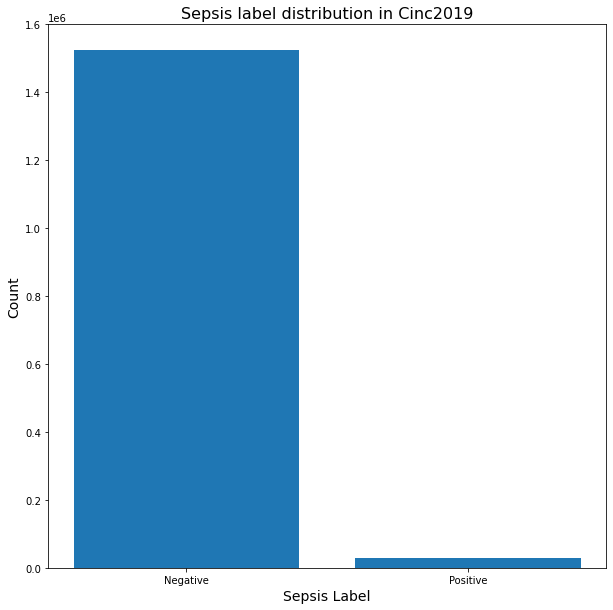

In [101]:
# sepsis ratio (label-wise)
sepsis_ratio = raw_data_all.groupby('SepsisLabel').count()['patient_id']
sepsis_dis = sepsis_ratio.values
print(sepsis_dis)

plt.figure(figsize=(10,10))
plt.bar(['Negative', 'Positive'],sepsis_dis)
plt.title('Sepsis label distribution in Cinc2019',size=16)
plt.ylabel('Count',size=14)
plt.xlabel('Sepsis Label',size=14)
plt.savefig('./data_figs/sepsis_label_distribution_cinc2019.pdf')

### Age Distribution

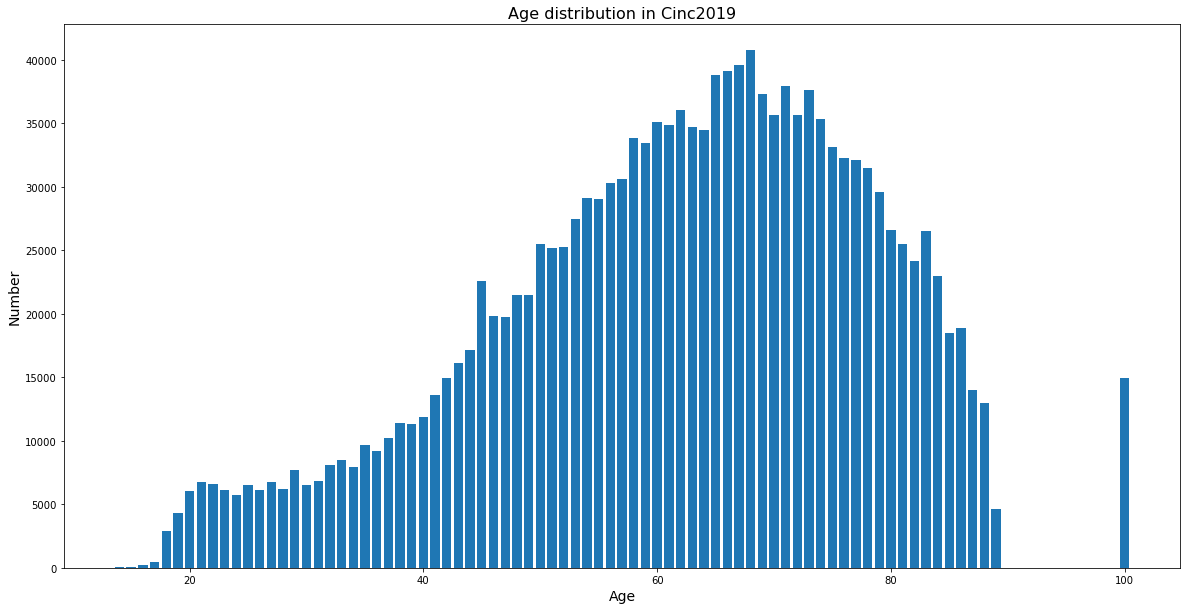

In [102]:
# age distribution
age_dis = raw_data_all.groupby('Age').count()['patient_id']
age_dis = pd.DataFrame({'age':age_dis.index, 'number':age_dis.values})

new_age_dis = pd.DataFrame(columns=['age','number'])
for age in range(14,101):
    age_dis_part = age_dis[(age <= age_dis['age']) &  (age_dis['age']< (age+1))]
    total_num = age_dis_part['number'].sum()
    new_age_dis = new_age_dis.append({'age':age, 'number': total_num}, ignore_index  =True)

plt.figure(figsize=(20,10))
plt.bar(new_age_dis.age, new_age_dis.number)
plt.title('Age distribution in Cinc2019',size=16)
plt.xlabel('Age',size=14)
plt.ylabel('Number',size=14)
plt.savefig('./data_figs/age_distribution_cinc2019.pdf')

### Empty Rate

In [87]:
# check empty rate
labs_df = raw_data_all[labs]
vitals_df = raw_data_all[vitals]
demogs_df = raw_data_all[demogs]

print('Empty rate in lab features:', np.mean((labs_df.isnull().sum() / labs_df.shape[0])))
print('Empty rate in vital sign features:', np.mean((vitals_df.isnull().sum() / vitals_df.shape[0])))
print('Empty rate in demographic features:', np.mean((demogs_df.isnull().sum() / demogs_df.shape[0])))

Empty rate in lab features: 0.948179345280897
Empty rate in vital sign features: 0.23262159851345593
Empty rate in demographic features: 1.2884854497780583e-06


<Figure size 1440x1440 with 0 Axes>

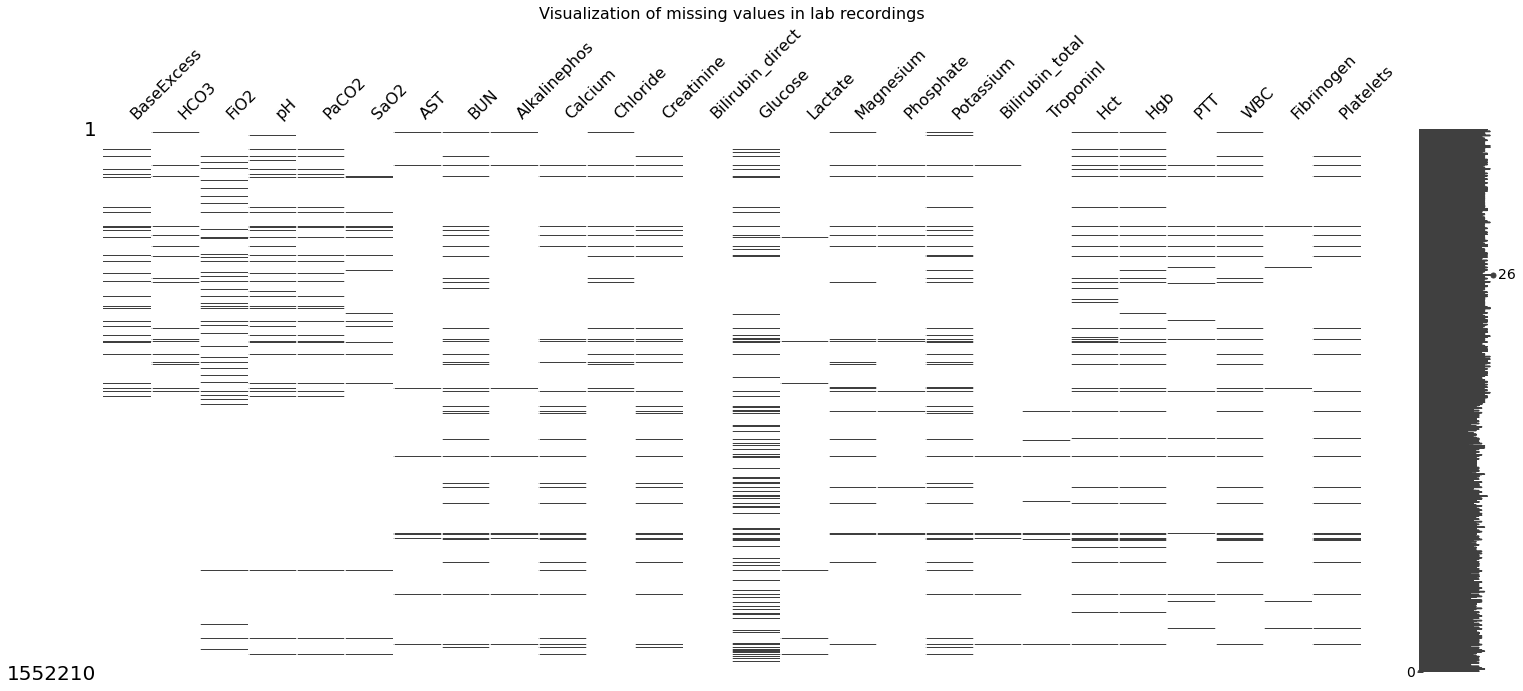

<Figure size 432x288 with 0 Axes>

In [94]:
plt.figure(figsize=(20,20))
msno.matrix(labs_df)
plt.title('Visualization of missing values in lab recordings', size=16)
plt.show()
plt.savefig('./data_figs/lab_missing_Cinc2019.pdf')

<Figure size 1440x1440 with 0 Axes>

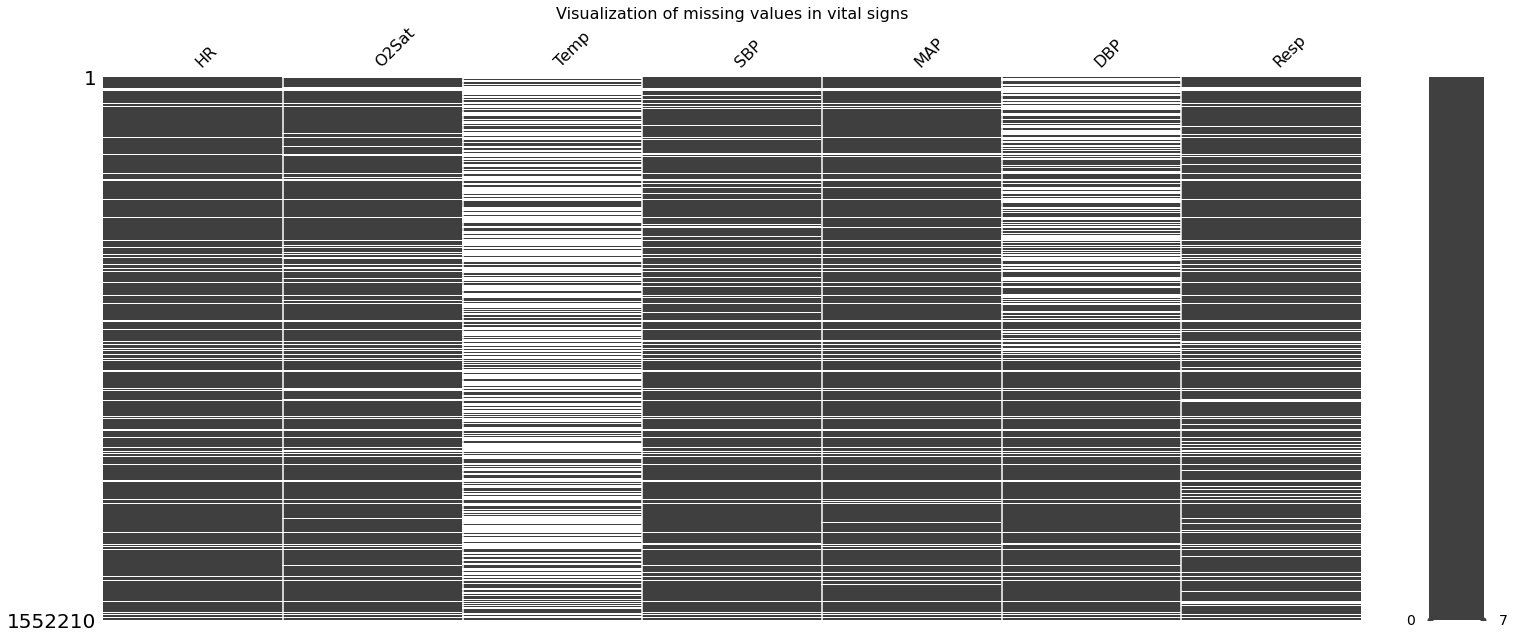

In [95]:
plt.figure(figsize=(20,20))
msno.matrix(vitals_df)
plt.title('Visualization of missing values in vital signs', size=16)
plt.show()
# plt.savefig('./data_figs/lab_missing_Cinc2019.pdf')

<Figure size 1440x1440 with 0 Axes>

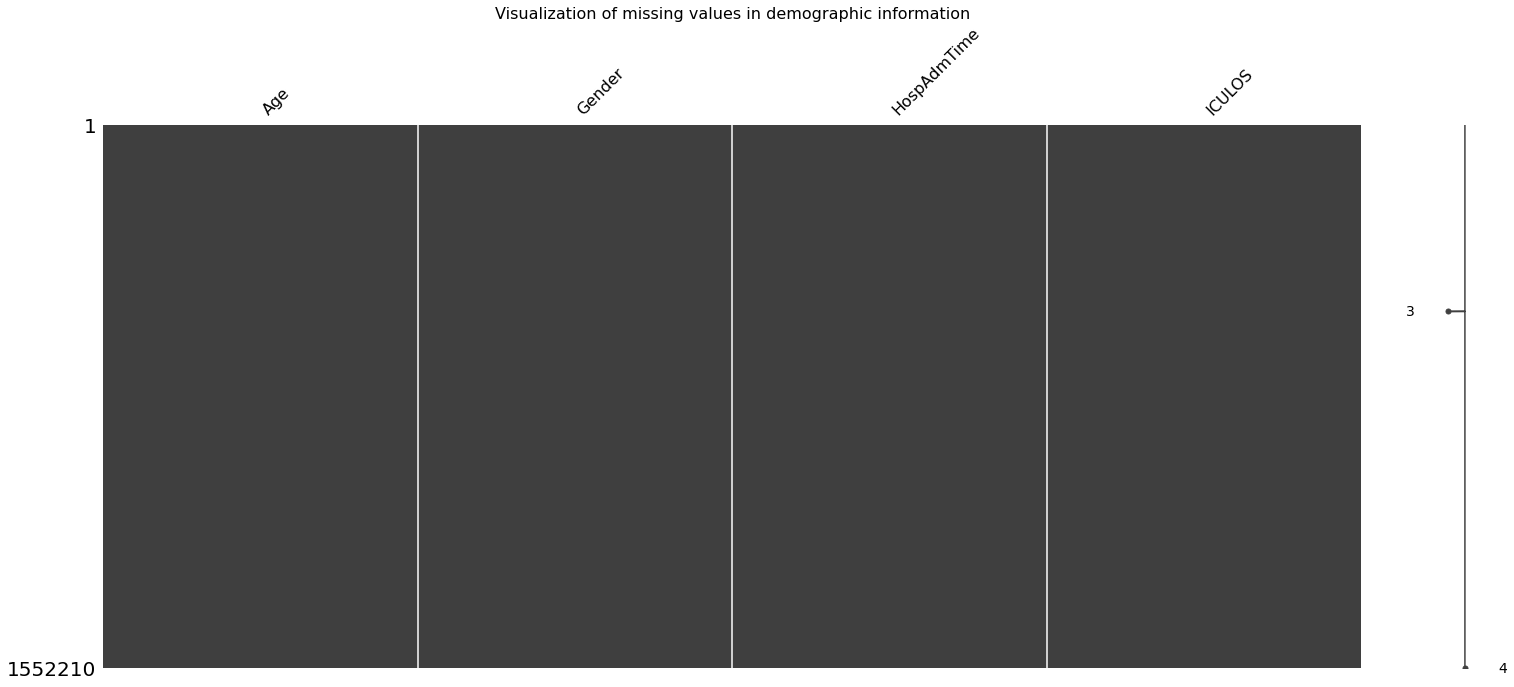

In [96]:
plt.figure(figsize=(20,20))
msno.matrix(demogs_df)
plt.title('Visualization of missing values in demographic information', size=16)
plt.show()
# plt.savefig('./data_figs/lab_missing_Cinc2019.pdf')

Number of featurs that contains null values 37


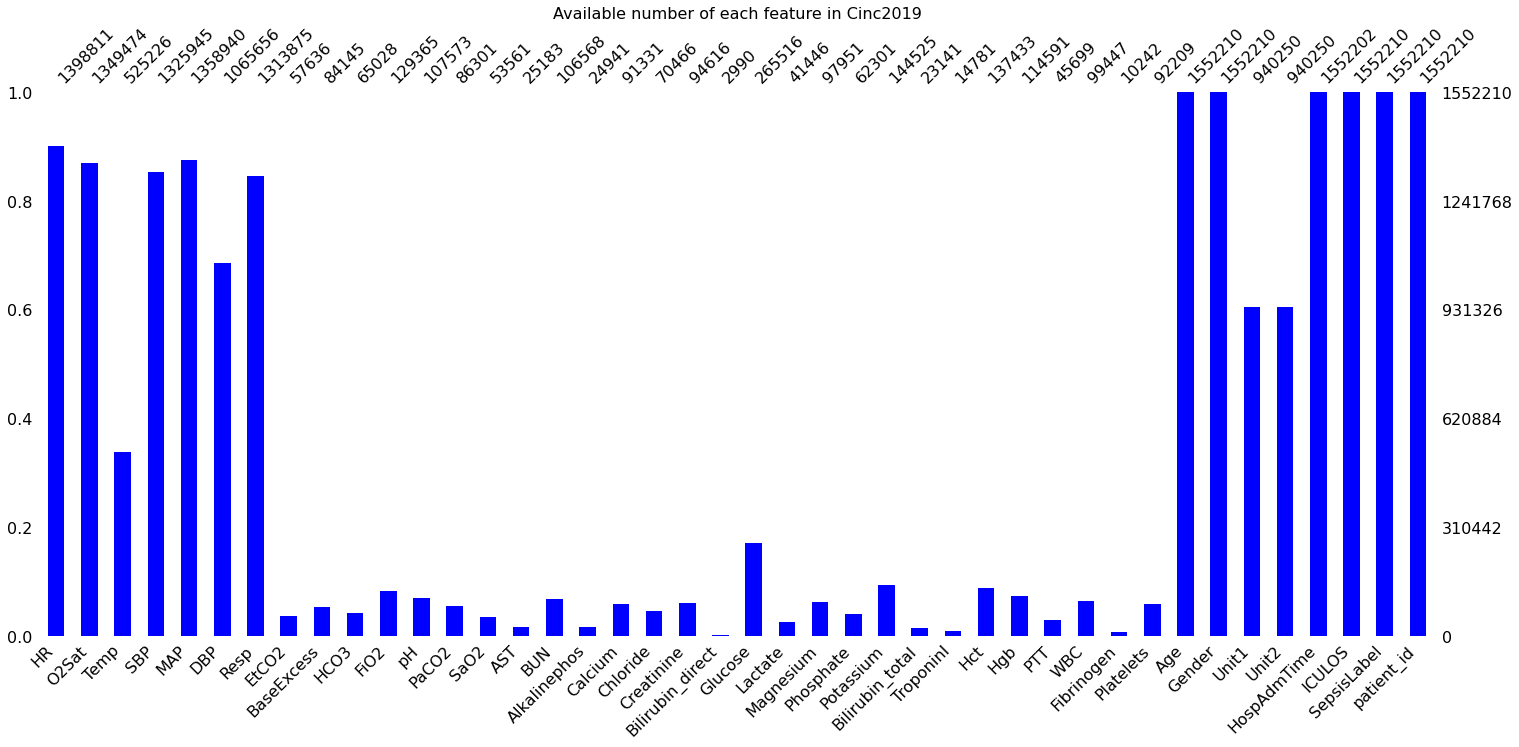

In [5]:
#pick out the columns that contain null data
missingdata_df = raw_data_all.columns[raw_data_all.isnull().any()].tolist()
print('Number of featurs that contains null values',len(missingdata_df))

plt.figure(figsize=(20,10))
msno.bar(raw_data_all, color="blue", log=False)
plt.title('Available number of each feature in Cinc2019', size=16)
plt.show()
# plt.savefig('./data_figs/lab_missing_Cinc2019.pdf')


In [ ]:
msno.heatmap(raw_data_all[missingdata_df])

## Others?

Files -> Pickle

In [ ]:
baseline_train_data = pd.DataFrame([])

for p in train_id:

    # read in patient data
    df = pd.read_csv('/content/baseline/train_baseline/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    baseline_train_data = pd.concat([baseline_train_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/baseline_train_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(baseline_train_data, f)

In [ ]:
baseline_val_data = pd.DataFrame([])

for p in val_id:

    # read in patient data
    df = pd.read_csv('/content/baseline/val_baseline/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    baseline_val_data = pd.concat([baseline_val_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/baseline_val_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(baseline_val_data, f)

In [ ]:
baseline_test_data = pd.DataFrame([])

for p in test_id:

    # read in patient data
    df = pd.read_csv('/content/baseline/test_baseline/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    baseline_test_data = pd.concat([baseline_test_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/baseline_test_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(baseline_test_data, f)

In [ ]:
print(baseline_train_data.shape)
print(baseline_val_data.shape)
print(baseline_test_data.shape)

(1087546, 42)
(231361, 42)
(233303, 42)


Pickle -> CSV

In [ ]:
filename = '/content/baseline_train_data.pickle'
with open(filename, 'rb') as f:
    baseline_train = pickle.load(f)

print(baseline_train.head())

     HR  O2Sat  Temp    SBP    MAP    DBP  Resp  BaseExcess  HCO3  FiO2  ...  \
0  73.0   95.0  36.7  173.5  146.0  136.5  15.5         0.0   0.0   0.0  ...   
1  73.0   95.0  36.7  173.5  146.0  136.5  15.5         0.0   0.0   0.0  ...   
2  93.5   94.5  36.7  160.0  112.0   99.5  15.5         0.0   0.0   0.0  ...   
3  80.0  100.0  36.7  149.0  101.0   86.0  14.0         0.0   0.0   0.0  ...   
4  97.0   98.0  36.7  148.0  120.0  110.0  16.0         0.0   0.0   0.0  ...   

   Platelets   Age  Gender  HospAdmTime  ICULOS  SepsisLabel     HR_dev  \
0      228.0  29.0       1        -6.33       1            0  11.344602   
1      228.0  29.0       1        -6.33       2            0  10.968136   
2      228.0  29.0       1        -6.33       3            0   7.141428   
3      228.0  29.0       1        -6.33       4            0   7.368853   
4      228.0  29.0       1        -6.33       5            0   1.095445   

   Resp_dev  Temp_dev  patient_id  
0  0.758288  0.000000      11996

In [ ]:
filename = '/content/baseline_val_data.pickle'
with open(filename, 'rb') as f:
    baseline_val = pickle.load(f)

print(baseline_val.head())

      HR  O2Sat  Temp   SBP   MAP   DBP  Resp  BaseExcess  HCO3  FiO2  ...  \
0    NaN    NaN   NaN   NaN   NaN   NaN   NaN         NaN   NaN   NaN  ...   
1  106.0   96.0  36.0  72.0  65.0  60.0  22.0         NaN   NaN   NaN  ...   
2  106.0    NaN   NaN  76.0  65.5  60.0  19.0         NaN   NaN   NaN  ...   
3  106.0    NaN   NaN  81.0  67.0  57.0  22.0         NaN   NaN   NaN  ...   
4  106.0   95.0  36.3  80.0  69.0  60.0  25.0         NaN   NaN   NaN  ...   

   Platelets   Age  Gender  HospAdmTime  ICULOS  SepsisLabel    HR_dev  \
0        NaN  40.0       1         -7.8       1            0  0.000000   
1        NaN  40.0       1         -7.8       2            0  0.000000   
2        NaN  40.0       1         -7.8       3            0  0.000000   
3        NaN  40.0       1         -7.8       4            0  1.788854   
4        NaN  40.0       1         -7.8       5            0  2.190890   

   Resp_dev  Temp_dev  patient_id  
0  2.449490  0.212132      119576  
1  2.167948  0

In [ ]:
filename = '/content/baseline_test_data.pickle'
with open(filename, 'rb') as f:
    baseline_test = pickle.load(f)

print(baseline_test.head())

     HR  O2Sat  Temp    SBP    MAP    DBP  Resp  BaseExcess  HCO3  FiO2  ...  \
0   NaN    NaN   NaN    NaN    NaN    NaN   NaN         NaN   NaN   NaN  ...   
1  51.0   98.0   NaN  127.0  116.5  107.0  13.0         NaN   NaN   NaN  ...   
2  44.0  100.0  36.2    NaN   72.0    NaN  11.0         NaN   NaN   NaN  ...   
3  52.0  100.0   NaN    NaN   54.0    NaN  10.0         NaN   NaN   NaN  ...   
4  48.0  100.0   NaN    NaN   63.0    NaN   NaN         NaN   NaN   NaN  ...   

   Platelets   Age  Gender  HospAdmTime  ICULOS  SepsisLabel    HR_dev  \
0        NaN  77.0       1        -6.59       1            0  3.593976   
1        NaN  77.0       1        -6.59       2            0  3.114482   
2      102.0  77.0       1        -6.59       3            0  3.435113   
3        NaN  77.0       1        -6.59       4            0  4.494441   
4        NaN  77.0       1        -6.59       5            0  4.358899   

   Resp_dev  Temp_dev  patient_id  
0  1.527525       NaN      104921  
1 

In [ ]:
td_num = []
for i in range(len(train_id)):
    temp = int(train_id[i][1:7])
    td_num.append(temp)
print(td_num)
print(len(td_num))

In [ ]:
baseline_train = baseline_train[baseline_train.patient_id.isin(td_num)]

In [ ]:
baseline_train.to_csv('/content/baseline_train.csv', sep = '|', index = False)

In [ ]:
pd.read_csv('/content/baseline_train.csv', sep = '|')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,HR_dev,Resp_dev,Temp_dev,patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,29.0,1,-6.33,1,0,11.286976,0.866025,NaN,119960
1,73.0,95.0,NaN,173.5,146.0,136.5,15.5,NaN,NaN,NaN,...,NaN,29.0,1,-6.33,2,0,10.968136,0.935414,NaN,119960
2,93.5,94.5,36.7,160.0,112.0,99.5,15.5,NaN,NaN,NaN,...,NaN,29.0,1,-6.33,3,0,7.141428,1.024695,NaN,119960
3,80.0,100.0,NaN,149.0,101.0,86.0,14.0,NaN,NaN,NaN,...,NaN,29.0,1,-6.33,4,0,7.368853,1.341641,NaN,119960
4,97.0,98.0,NaN,148.0,120.0,110.0,16.0,NaN,NaN,NaN,...,NaN,29.0,1,-6.33,5,0,1.095445,1.140175,NaN,119960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087541,82.0,99.0,NaN,98.0,66.0,48.0,13.0,NaN,NaN,NaN,...,NaN,49.0,0,-172.37,47,0,7.797435,1.204159,NaN,101764
1087542,88.0,98.0,NaN,94.0,64.0,48.0,15.0,NaN,NaN,NaN,...,NaN,49.0,0,-172.37,48,0,5.852350,1.108678,NaN,101764
1087543,97.0,98.0,NaN,96.0,64.0,46.0,13.5,NaN,NaN,NaN,...,NaN,49.0,0,-172.37,49,0,4.041452,1.322876,NaN,101764
1087544,102.0,99.0,36.0,91.0,63.0,46.0,14.0,NaN,NaN,NaN,...,NaN,49.0,0,-172.37,50,0,5.656854,1.414214,NaN,101764


In [ ]:
val_num = []
for i in range(len(val_id)):
    temp = int(val_id[i][1:7])
    val_num.append(temp)
    
baseline_val = baseline_val[baseline_val.patient_id.isin(val_num)]

In [ ]:
baseline_val.to_csv('/content/baseline_val.csv', sep = '|', index = False)

In [ ]:
pd.read_csv('/content/baseline_val.csv', sep = '|')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,HR_dev,Resp_dev,Temp_dev,patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,40.00,1,-7.80,1,0,0.000000,2.449490,0.212132,119576
1,106.0,96.0,36.00,72.0,65.0,60.0,22.0,NaN,NaN,NaN,...,NaN,40.00,1,-7.80,2,0,0.000000,2.167948,0.212132,119576
2,106.0,NaN,NaN,76.0,65.5,60.0,19.0,NaN,NaN,NaN,...,NaN,40.00,1,-7.80,3,0,0.000000,3.033150,NaN,119576
3,106.0,NaN,NaN,81.0,67.0,57.0,22.0,NaN,NaN,NaN,...,NaN,40.00,1,-7.80,4,0,1.788854,2.408319,NaN,119576
4,106.0,95.0,36.30,80.0,69.0,60.0,25.0,NaN,NaN,NaN,...,NaN,40.00,1,-7.80,5,0,2.190890,2.280351,0.282843,119576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232258,84.0,98.0,36.61,95.5,68.0,53.5,11.5,NaN,NaN,NaN,...,NaN,56.92,1,-3.98,17,0,3.041381,2.043282,0.155563,16885
232259,77.5,100.0,NaN,93.5,72.0,59.5,13.0,NaN,NaN,NaN,...,NaN,56.92,1,-3.98,18,0,1.973787,1.931105,NaN,16885
232260,76.0,100.0,NaN,102.0,76.5,68.0,13.5,NaN,NaN,NaN,...,NaN,56.92,1,-3.98,19,0,2.309401,2.179449,NaN,16885
232261,80.0,100.0,NaN,108.5,76.0,67.5,17.0,NaN,NaN,NaN,...,NaN,56.92,1,-3.98,20,0,0.000000,2.828427,NaN,16885


In [ ]:
test_num = []
for i in range(len(test_id)):
    temp = int(list(test_id)[i][1:7])
    test_num.append(temp)
    
baseline_test = baseline_test[baseline_test.patient_id.isin(test_num)]

In [ ]:
baseline_test.to_csv('/content/baseline_test.csv', sep = '|', index = False)

In [ ]:
pd.read_csv('/content/baseline_test.csv', sep = '|')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Platelets,Age,Gender,HospAdmTime,ICULOS,SepsisLabel,HR_dev,Resp_dev,Temp_dev,patient_id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,77.0,1,-6.59,1,0,3.593976,1.527525,NaN,104921
1,51.0,98.0,NaN,127.0,116.5,107.0,13.0,NaN,NaN,NaN,...,NaN,77.0,1,-6.59,2,0,3.114482,3.559026,NaN,104921
2,44.0,100.0,36.2,NaN,72.0,NaN,11.0,NaN,NaN,NaN,...,102.0,77.0,1,-6.59,3,0,3.435113,4.349329,0.212132,104921
3,52.0,100.0,NaN,NaN,54.0,NaN,10.0,NaN,NaN,NaN,...,NaN,77.0,1,-6.59,4,0,4.494441,4.434712,NaN,104921
4,48.0,100.0,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,...,NaN,77.0,1,-6.59,5,0,4.358899,1.000000,NaN,104921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232396,78.0,94.0,NaN,180.0,113.0,66.0,16.0,NaN,NaN,NaN,...,NaN,67.0,0,-5.10,11,0,4.324350,1.732051,0.777817,100208
232397,75.0,93.0,36.0,196.0,120.0,84.0,20.0,NaN,NaN,NaN,...,NaN,67.0,0,-5.10,12,0,3.696846,1.892969,0.777817,100208
232398,70.0,96.0,NaN,177.0,110.0,77.0,16.0,NaN,NaN,NaN,...,NaN,67.0,0,-5.10,13,0,3.511885,0.577350,NaN,100208
232399,67.0,97.5,37.1,167.5,124.0,75.5,17.0,NaN,NaN,NaN,...,NaN,67.0,0,-5.10,14,0,4.949747,0.707107,NaN,100208


### Engineered Split

New Directories for baseline dataset

In [ ]:
!mkdir -p /content/engineered/train_engineered
!mkdir -p /content/engineered/val_engineered
!mkdir -p /content/engineered/test_engineered

In [ ]:
#function 2 test
df1 = pd.read_csv(path_all + '/' + 'p000001.psv', sep = '|')
print('Original: ',df1.head())
attributes = df1.columns[:-1]
# impute missing values
df_filled = impute_missing_vals(df1, attributes)
print('Filled: ',df_filled.head())
print(np.any(np.isnan(df_filled)))

df_eng = new_features(df_filled)
print('Engineered: ',df_eng.head())
print('Engineered: ',df_eng.tail())
print(np.any(pd.isnull(df_eng)))

Original:        HR  O2Sat  Temp    SBP    MAP  DBP  Resp  EtCO2  BaseExcess  HCO3  ...  \
0    NaN    NaN   NaN    NaN    NaN  NaN   NaN    NaN         NaN   NaN  ...   
1   97.0   95.0   NaN   98.0  75.33  NaN  19.0    NaN         NaN   NaN  ...   
2   89.0   99.0   NaN  122.0  86.00  NaN  22.0    NaN         NaN   NaN  ...   
3   90.0   95.0   NaN    NaN    NaN  NaN  30.0    NaN        24.0   NaN  ...   
4  103.0   88.5   NaN  122.0  91.33  NaN  24.5    NaN         NaN   NaN  ...   

   WBC  Fibrinogen  Platelets    Age  Gender  Unit1  Unit2  HospAdmTime  \
0  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
1  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
2  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
3  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   
4  NaN         NaN        NaN  83.14       0    NaN    NaN        -0.03   

   ICULOS  SepsisLabel  
0       1            0  
1      

In [ ]:
# impute missing values and create clean dfs for all patients
for p in patient_id:
    
    # read in patient data
    df = pd.read_csv(path_all + '/' + p, sep = "|")
    attributes = df.columns[:-1]
    
    # impute missing values
    df_filled = impute_missing_vals(df, attributes)
    # add features of deviation
    df_engineered = new_features(df_filled)
    
    # drop unit1 and unit2 with half missing values
    # because these two features have few information
    # drop EtCO2 with all missing values
    df_clean = df_engineered.drop(['Unit1', 'Unit2', 'EtCO2'], axis=1)
    
    # save new patient data
    if p in train_id:
        save_path = '/content/engineered/train_engineered/'
        df_clean.to_csv(save_path + p, sep='|', index = False)        
    
    elif p in val_id:
        save_path = '/content/engineered/val_engineered//'
        df_clean.to_csv(save_path + p, sep='|', index = False)        
    
    else:
        
        save_path = '/content/engineered/test_engineered//'
        df_clean.to_csv(save_path + p, sep='|', index = False)
    
    print(p)

Streaming output truncated to the last 5000 lines.
p115001.psv
p115002.psv
p115003.psv
p115004.psv
p115005.psv
p115006.psv
p115007.psv
p115008.psv
p115009.psv
p115010.psv
p115011.psv
p115012.psv
p115013.psv
p115014.psv
p115015.psv
p115016.psv
p115017.psv
p115018.psv
p115019.psv
p115020.psv
p115021.psv
p115022.psv
p115023.psv
p115024.psv
p115025.psv
p115026.psv
p115027.psv
p115028.psv
p115029.psv
p115030.psv
p115031.psv
p115032.psv
p115033.psv
p115034.psv
p115035.psv
p115036.psv
p115037.psv
p115038.psv
p115039.psv
p115040.psv
p115041.psv
p115042.psv
p115043.psv
p115044.psv
p115045.psv
p115046.psv
p115047.psv
p115048.psv
p115049.psv
p115050.psv
p115051.psv
p115052.psv
p115053.psv
p115054.psv
p115055.psv
p115056.psv
p115057.psv
p115058.psv
p115059.psv
p115060.psv
p115061.psv
p115062.psv
p115063.psv
p115064.psv
p115065.psv
p115066.psv
p115067.psv
p115068.psv
p115069.psv
p115070.psv
p115071.psv
p115072.psv
p115073.psv
p115074.psv
p115075.psv
p115076.psv
p115077.psv
p115078.psv
p115079.psv
p

Files -> Pickle

In [ ]:
engineered_train_data = pd.DataFrame([])

for p in train_id:

    # read in patient data
    df = pd.read_csv('/content/engineered/train_engineered/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    engineered_train_data = pd.concat([engineered_train_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/engineered_train_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(engineered_train_data, f)

In [ ]:
engineered_val_data = pd.DataFrame([])

for p in val_id:

    # read in patient data
    df = pd.read_csv('/content/engineered/val_engineered/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    engineered_val_data = pd.concat([engineered_val_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/engineered_val_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(engineered_val_data, f)

In [ ]:
engineered_test_data = pd.DataFrame([])

for p in test_id:

    # read in patient data
    df = pd.read_csv('/content/engineered/test_engineered/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    engineered_test_data = pd.concat([engineered_test_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/engineered_test_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(engineered_test_data, f)

In [ ]:
print(engineered_train_data.shape)
print(engineered_val_data.shape)
print(engineered_test_data.shape)

(1087546, 53)
(233247, 53)
(231417, 53)


Pickle -> CSV

In [ ]:
filename = '/content/engineered_train_data.pickle'
with open(filename, 'rb') as f:
    engineered_train = pickle.load(f)

print(engineered_train.head())

     HR  O2Sat  Temp    SBP    MAP    DBP  Resp  BaseExcess  HCO3  FiO2  ...  \
0  73.0   95.0  36.7  173.5  146.0  136.5  15.5         0.0   0.0   0.0  ...   
1  73.0   95.0  36.7  173.5  146.0  136.5  15.5         0.0   0.0   0.0  ...   
2  93.5   94.5  36.7  160.0  112.0   99.5  15.5         0.0   0.0   0.0  ...   
3  80.0  100.0  36.7  149.0  101.0   86.0  14.0         0.0   0.0   0.0  ...   
4  97.0   98.0  36.7  148.0  120.0  110.0  16.0         0.0   0.0   0.0  ...   

   Resp_dev_3  Temp_dev_1  Temp_dev_2  Temp_dev_3  Bradycardia  Tachycardia  \
0    2.490531    0.258199    0.258199    0.258199        False        False   
1    2.514364    0.260595    0.260595    0.260595        False        False   
2    2.538894    0.263060    0.263060    0.263060        False        False   
3    2.564157    0.265596    0.265596    0.265596        False        False   
4    2.581251    0.268206    0.268206    0.268206        False        False   

   Hypothermia  Fever  Hyperpyrexia  patient

In [ ]:
filename = '/content/engineered_val_data.pickle'
with open(filename, 'rb') as f:
    engineered_val = pickle.load(f)

print(engineered_val.head())

     HR  O2Sat   Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  FiO2  ...  \
0  72.0  100.0  35.40  105.0  62.5  44.5  15.5        -2.0  22.0   1.0  ...   
1  80.0  100.0  35.85  117.5  70.5  52.0  14.0        -2.0  22.0   0.7  ...   
2  80.0  100.0  36.75  112.0  69.0  52.0  16.0        -1.0  22.0   0.7  ...   
3  80.0  100.0  36.95  104.5  66.5  51.5  16.0        -1.0  22.0   0.6  ...   
4  80.0  100.0  36.90  100.0  65.0  51.0  16.0        -2.0  22.0   0.6  ...   

   Resp_dev_3  Temp_dev_1  Temp_dev_2  Temp_dev_3  Bradycardia  Tachycardia  \
0    2.797057    0.826306    0.826306    0.826306        False        False   
1    2.878035    0.662799    0.662799    0.662799        False        False   
2    2.913868    0.501224    0.501224    0.501224        False        False   
3    3.014647    0.445836    0.445836    0.445836        False        False   
4    3.126675    0.397390    0.397390    0.397390        False        False   

   Hypothermia  Fever  Hyperpyrexia  patient_id  


In [ ]:
filename = '/content/engineered_test_data.pickle'
with open(filename, 'rb') as f:
    engineered_test = pickle.load(f)

print(engineered_test.head())

      HR  O2Sat  Temp    SBP   MAP   DBP  Resp  BaseExcess  HCO3  FiO2  ...  \
0  112.0   99.0  36.8  116.0  81.0  59.0  10.0         0.0   0.0   0.0  ...   
1  112.0   99.0  36.8  116.0  81.0  59.0  10.0         0.0   0.0   0.0  ...   
2  105.0   99.5  36.8  119.0  82.0  60.0  11.0         0.0   0.0   0.0  ...   
3  102.0  100.0  36.8  116.0  83.0  62.0   9.5         0.0   0.0   0.0  ...   
4  100.0  100.0  36.8  116.0  78.0  56.0  10.0         0.0   0.0   0.0  ...   

   Resp_dev_3  Temp_dev_1  Temp_dev_2  Temp_dev_3  Bradycardia  Tachycardia  \
0    5.147994    0.125062    0.125062    0.125062        False         True   
1    5.136883    0.124881    0.124881    0.124881        False         True   
2    5.116659    0.124493    0.124493    0.124493        False         True   
3    5.127753    0.123849    0.123849    0.123849        False         True   
4    5.059809    0.122882    0.122882    0.122882        False        False   

   Hypothermia  Fever  Hyperpyrexia  patient_id  


In [ ]:
td_num = []
for i in range(len(train_id)):
    temp = int(train_id[i][1:7])
    td_num.append(temp)
print(td_num)
print(len(td_num))

[119960, 118037, 15940, 119340, 2381, 18320, 117532, 5606, 102343, 15677, 2224, 105045, 4542, 4071, 7916, 3452, 2752, 104171, 102351, 115021, 107385, 2873, 9472, 100766, 112210, 104945, 142, 101601, 113624, 18416, 10751, 15299, 103929, 119148, 18253, 100372, 8654, 118429, 16683, 3948, 100410, 113438, 9349, 16543, 117473, 5800, 119072, 119855, 112841, 18977, 14072, 189, 118079, 107413, 103758, 112688, 20579, 113690, 103991, 119021, 110985, 16739, 104798, 116533, 113636, 6291, 111669, 7703, 14252, 112769, 3714, 110505, 115504, 2654, 2527, 118184, 16042, 110854, 114148, 20335, 16970, 19499, 2297, 110081, 114514, 19704, 106803, 14915, 11950, 1423, 103547, 10624, 115099, 119408, 112915, 18310, 106286, 102341, 110486, 16382, 118046, 114097, 113491, 12506, 4569, 110313, 8143, 18896, 117893, 14822, 107157, 114100, 6499, 107115, 110946, 114770, 13132, 2344, 5492, 17993, 108159, 100781, 7648, 118602, 108318, 5288, 12869, 11732, 1612, 116708, 11733, 12556, 3129, 14564, 105743, 102106, 15892, 6388

In [ ]:
engineered_train = engineered_train[engineered_train.patient_id.isin(td_num)]

In [ ]:
engineered_train.to_csv('/content/engineered_train.csv', sep = '|', index = False)

In [ ]:
pd.read_csv('/content/engineered_train.csv', sep = '|')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Resp_dev_3,Temp_dev_1,Temp_dev_2,Temp_dev_3,Bradycardia,Tachycardia,Hypothermia,Fever,Hyperpyrexia,patient_id
0,73.0,95.0,36.7,173.5,146.0,136.5,15.5,0.0,0.0,0.0,...,2.490531,0.258199,0.258199,0.258199,False,False,False,False,False,119960
1,73.0,95.0,36.7,173.5,146.0,136.5,15.5,0.0,0.0,0.0,...,2.514364,0.260595,0.260595,0.260595,False,False,False,False,False,119960
2,93.5,94.5,36.7,160.0,112.0,99.5,15.5,0.0,0.0,0.0,...,2.538894,0.263060,0.263060,0.263060,False,False,False,False,False,119960
3,80.0,100.0,36.7,149.0,101.0,86.0,14.0,0.0,0.0,0.0,...,2.564157,0.265596,0.265596,0.265596,False,False,False,False,False,119960
4,97.0,98.0,36.7,148.0,120.0,110.0,16.0,0.0,0.0,0.0,...,2.581251,0.268206,0.268206,0.268206,False,False,False,False,False,119960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087541,82.0,99.0,35.6,98.0,66.0,48.0,13.0,0.0,0.0,0.5,...,1.204159,0.219089,0.219089,0.219089,False,False,False,False,False,101764
1087542,88.0,98.0,35.6,94.0,64.0,48.0,15.0,0.0,0.0,0.5,...,1.108678,0.200000,0.200000,0.200000,False,False,False,False,False,101764
1087543,97.0,98.0,36.0,96.0,64.0,46.0,13.5,0.0,0.0,0.5,...,1.322876,0.000000,0.000000,0.000000,False,False,False,False,False,101764
1087544,102.0,99.0,36.0,91.0,63.0,46.0,14.0,0.0,0.0,0.5,...,1.414214,0.000000,0.000000,0.000000,False,True,False,False,False,101764


In [ ]:
val_num = []
for i in range(len(val_id)):
    temp = int(val_id[i][1:7])
    val_num.append(temp)
    
engineered_val = engineered_val[engineered_val.patient_id.isin(val_num)]

In [ ]:
engineered_val.to_csv('/content/engineered_val.csv', sep = '|', index = False)

In [ ]:
pd.read_csv('/content/engineered_val.csv', sep = '|')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Resp_dev_3,Temp_dev_1,Temp_dev_2,Temp_dev_3,Bradycardia,Tachycardia,Hypothermia,Fever,Hyperpyrexia,patient_id
0,72.0,100.0,35.40,105.0,62.50,44.5,15.5,-2.0,22.0,1.0,...,2.797057,0.826306,0.826306,0.826306,False,False,False,False,False,61
1,80.0,100.0,35.85,117.5,70.50,52.0,14.0,-2.0,22.0,0.7,...,2.878035,0.662799,0.662799,0.662799,False,False,False,False,False,61
2,80.0,100.0,36.75,112.0,69.00,52.0,16.0,-1.0,22.0,0.7,...,2.913868,0.501224,0.501224,0.501224,False,False,False,False,False,61
3,80.0,100.0,36.95,104.5,66.50,51.5,16.0,-1.0,22.0,0.6,...,3.014647,0.445836,0.445836,0.445836,False,False,False,False,False,61
4,80.0,100.0,36.90,100.0,65.00,51.0,16.0,-2.0,22.0,0.6,...,3.126675,0.397390,0.397390,0.397390,False,False,False,False,False,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233242,73.0,98.0,35.72,108.0,80.00,54.0,19.0,0.0,26.0,0.0,...,2.280351,0.000000,0.000000,0.000000,False,False,False,False,False,2028
233243,77.0,98.0,35.72,130.0,88.00,58.0,18.0,0.0,26.0,0.0,...,2.629956,0.000000,0.000000,0.000000,False,False,False,False,False,2028
233244,76.0,99.0,35.72,118.0,77.33,58.0,19.0,0.0,26.0,0.0,...,3.055050,0.000000,0.000000,0.000000,False,False,False,False,False,2028
233245,79.0,99.0,35.72,145.0,95.67,58.0,17.0,0.0,26.0,0.0,...,4.242641,0.000000,0.000000,0.000000,False,False,False,False,False,2028


In [ ]:
test_num = []
for i in range(len(test_id)):
    temp = int(list(test_id)[i][1:7])
    test_num.append(temp)
    
engineered_test = engineered_test[engineered_test.patient_id.isin(test_num)]

In [ ]:
engineered_test.to_csv('/content/engineered_test.csv', sep = '|', index = False)

In [ ]:
pd.read_csv('/content/engineered_test.csv', sep = '|')

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Resp_dev_3,Temp_dev_1,Temp_dev_2,Temp_dev_3,Bradycardia,Tachycardia,Hypothermia,Fever,Hyperpyrexia,patient_id
0,112.0,99.0,36.80,116.00,81.00,59.0,10.0,0.0,0.0,0.0,...,5.147994,0.125062,0.125062,0.125062,False,True,False,False,False,112636
1,112.0,99.0,36.80,116.00,81.00,59.0,10.0,0.0,0.0,0.0,...,5.136883,0.124881,0.124881,0.124881,False,True,False,False,False,112636
2,105.0,99.5,36.80,119.00,82.00,60.0,11.0,0.0,0.0,0.0,...,5.116659,0.124493,0.124493,0.124493,False,True,False,False,False,112636
3,102.0,100.0,36.80,116.00,83.00,62.0,9.5,0.0,0.0,0.0,...,5.127753,0.123849,0.123849,0.123849,False,True,False,False,False,112636
4,100.0,100.0,36.80,116.00,78.00,56.0,10.0,0.0,0.0,0.0,...,5.059809,0.122882,0.122882,0.122882,False,False,False,False,False,112636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231412,97.0,97.0,37.30,103.00,60.67,46.0,16.0,-4.0,18.0,0.6,...,2.880972,0.114018,0.114018,0.114018,False,False,False,False,False,2749
231413,98.0,99.0,37.25,87.25,59.83,51.0,20.0,-4.0,18.0,0.6,...,2.500000,0.131498,0.131498,0.131498,False,False,False,False,False,2749
231414,90.0,100.0,37.20,100.00,67.33,57.0,21.0,-4.0,18.0,0.5,...,3.055050,0.152753,0.152753,0.152753,False,False,False,False,False,2749
231415,93.0,99.0,37.30,117.00,69.67,57.0,23.0,-4.0,18.0,0.5,...,4.242641,0.141421,0.141421,0.141421,False,False,False,False,False,2749


### Raw split

In [ ]:



!mkdir -p /content/raw/training
!mkdir -p /content/raw/validation
!mkdir -p /content/raw/test
data_train = '/content/raw/training/'
data_val = '/content/raw/validation/'
data_test = '/content/raw/test/'
Split
for p in train_id:
    df = pd.read_csv(path_all + '/' + p, sep = "|")
    df.to_csv(data_train  + p, sep='|', index = False) 
for p in val_id:
    df = pd.read_csv(path_all + '/' + p, sep = "|")
    df.to_csv(data_val + p, sep='|', index = False) 
for p in test_id:
    df = pd.read_csv(path_all + '/' + p, sep = "|")
    df.to_csv(data_test + p, sep='|', index = False)
Files -> Pickle
#raw data of the whole dataset
raw_data = pd.DataFrame([])

for p in patient_id:

    # read in patient data
    df = pd.read_csv('/content/training_setAB/' + p, sep = "|")
    
    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    raw_data = pd.concat([raw_data, df], ignore_index=False)

import pickle
filename = '/content/raw_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(raw_data, f)
raw_train_data = pd.DataFrame([])

for p in train_id:

    # read in patient data
    df = pd.read_csv('/content/raw/training/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    raw_train_data = pd.concat([raw_train_data, df], ignore_index=False)
    
import pickle
filename = '/content/raw_train_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(raw_train_data, f)
raw_val_data = pd.DataFrame([])

for p in val_id:

    # read in patient data
    df = pd.read_csv('/content/raw/validation/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    raw_val_data = pd.concat([raw_val_data, df], ignore_index=False)
    
import pickle
filename = '/content/raw_val_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(raw_val_data, f)
raw_test_data = pd.DataFrame([])

for p in test_id:

    # read in patient data
    df = pd.read_csv('/content/raw/test/' + p, sep = "|")

    attributes = df.columns[:-1]
    df['patient_id'] = int(p.replace('p', '').replace('.sv', ''))
    
    raw_test_data = pd.concat([raw_test_data, df], ignore_index=False)  #True or False
    
import pickle
filename = '/content/raw_test_data.pickle'
with open(filename, "wb") as f:
    pickle.dump(raw_test_data, f)
Check the shape of traning, val and test dataset
print(raw_data.shape)
print(raw_train_data.shape)
print(raw_val_data.shape)
print(raw_test_data.shape)
Pickle -> CSV
#raw_data
filename = '/content/raw_data.pickle'
with open(filename, 'rb') as f:
    raw = pickle.load(f)

raw.to_csv('/content/raw_data.csv', sep = '|', index = False)
pd.read_csv('/content/raw_data.csv', sep = '|')
#raw_train
filename = '/content/raw_train_data.pickle'
with open(filename, 'rb') as f:
    raw_train = pickle.load(f)

raw_train.to_csv('/content/raw_train.csv', sep = '|', index = False)
pd.read_csv('/content/raw_train.csv', sep = '|')
#raw_val
filename = '/content/raw_val_data.pickle'
with open(filename, 'rb') as f:
    raw_val = pickle.load(f)

raw_val.to_csv('/content/raw_val.csv', sep = '|', index = False)
pd.read_csv('/content/raw_val.csv', sep = '|')
#raw_test
filename = '/content/raw_test_data.pickle'
with open(filename, 'rb') as f:
    raw_test = pickle.load(f)

raw_test.to_csv('/content/raw_test.csv', sep = '|', index = False)
pd.read_csv('/content/raw_test.csv', sep = '|')